In [1]:
from __future__ import print_function
import steps.model as smodel
import steps.solver as ssolver
import steps.geom as swm
import steps.rng as srng
import steps.utilities.meshio as sutils

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as itp
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import os

from parameters_with_leak import *
from misc import *
from components_with_leak import *

import pickle as pkl
import networkx as nx

from outputloc import outputloc

## Casewise parameter changes

In [2]:
case=['control','2x','3x'][0]

#Control. Full leak. Eq at 250um ER conc
if case=='control':
    initV['Ca'][1]=250e-6
    initV['serca']=[0.18242194125978026,0.35660284415866084,0.17426944131595862,0.23602495205009327,0.04816246512327335,0.0025183560706803516]
    k_leak=186.74888

#2 fold ER overload. 30% leak. Eq at 500um ER
if case=='2x':
    initV['Ca'][1]=500e-6
    initV['serca']=[0.18631139409722924,0.36429787489044535,0.17807592032910588,0.18720596785329524,0.07629273337917962,0.00781610945339272]
    k_leak=186.74888*0.3

#3 fold ER overload. 20% leak. Eq at 750um ER
if case=='3x':
    initV['Ca'][1]=750e-6
    initV['serca']=[0.19379038120694989,0.3790117340395536,0.18531341504308455,0.14190562498324744,0.08670581220565597,0.013273032416232263]
    k_leak=186.74888*0.2

In [3]:
initV

{'Ca': [1e-07, 0.00025],
 'HH': [-64.0, 0.05, 0.6, 0.32],
 'PMCA': [1224, 298, 7],
 'VDCC': [80, 0.0, 0.0, 0.0, 0.0, 0.0],
 'cb': [1.48e-05,
  7e-06,
  8.27e-07,
  1.21e-05,
  5.74e-06,
  6.79e-07,
  2.49e-06,
  1.18e-06,
  1.39e-07],
 'AZ': [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'serca': [0.18242194125978026,
  0.35660284415866084,
  0.17426944131595862,
  0.23602495205009327,
  0.04816246512327335,
  0.0025183560706803516],
 'ryr': [150, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'leak': [8680]}

### Loading vdcc_dat for given ISI

In [4]:
isi=20
loc="/home/kabir/Project/tripartiteSynapse/mcell"
VDCC_rates={
'VDCC_C01' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C01_" + str(isi) + "ms_ppf.dat"),
'VDCC_C12' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C12_" + str(isi) + "ms_ppf.dat"),
'VDCC_C23' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C23_" + str(isi) + "ms_ppf.dat"),
'VDCC_C3O' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C34_" + str(isi) + "ms_ppf.dat"),
'VDCC_OC3' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C43_" + str(isi) + "ms_ppf.dat"),
'VDCC_C32' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C32_" + str(isi) + "ms_ppf.dat"),
'VDCC_C21' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C21_" + str(isi) + "ms_ppf.dat"),
'VDCC_C10' : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_C10_" + str(isi) + "ms_ppf.dat"),
'VDCCflux'  : np.loadtxt(loc+"/vdcc_dat/VDCC_PQ_Ca_"  + str(isi) + "ms_ppf.dat")} 

#fitting cubic splines
VDCC_spline={}
for key in VDCC_rates.keys():
    VDCC_spline[key]=itp.interp1d(VDCC_rates[key].T[0],VDCC_rates[key].T[1],kind='previous',fill_value=(np.nan, VDCC_rates[key].T[1][-1]), bounds_error=False)

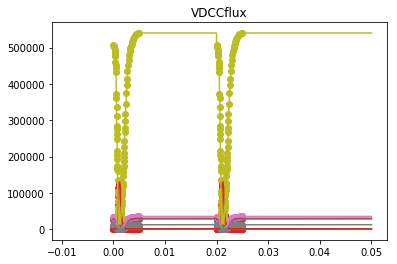

In [5]:
for key in VDCC_spline.keys():
    #plt.figure(figsize=(20,10))
    #VDCC_spline[key](0)
    plt.title(key)
    plt.scatter(VDCC_rates[key].T[0],VDCC_rates[key].T[1])
    x=np.linspace(0,0.050,10000)
    plt.plot(x,VDCC_spline[key](x))
    #float(itp.splev(1,VDCC_spline['VDCC_C3O'],der=0))

In [6]:
class model_part:
    def __init__(self,name,molnames,init,system,mdl,Ca,get_function,geom,):
        self.name,self.molnames,self.init,self.system,self.mdl,self.Ca,self.get_function=name,molnames,init,system,mdl,Ca,get_function
        self.geom=geom
        self.mol_num=len(self.molnames)
        self.get_part()
        
        
    def get_part(self):
        self.Mol,self.R_part=self.get_function(self.system,self.mdl,self.Ca)
        
    def initialize(self,sim,subsystem=[]):
        if str(self.system.__class__)=="<class 'steps.model.Surfsys'>" and subsystem==[]:
            self.setCount=sim.setPatchCount
            self.getCount=sim.getPatchCount
        elif str(self.system.__class__)=="<class 'steps.model.Volsys'>" and subsystem==[]:
            self.setCount=sim.setCompConc
            self.getCount=sim.getCompCount
        elif str(self.system.__class__)=="<class 'steps.model.Surfsys'>" and subsystem!=[]:
            self.setCount=sim.setTriCount
            self.getCount=sim.getTriCount
        elif str(self.system.__class__)=="<class 'steps.model.Volsys'>" and subsystem!=[]:
            self.setCount=sim.setTetCount
            self.getCount=sim.getTetCount
            
        for mol,ic in zip(self.molnames,self.init):
            if subsystem==[]:               
                self.setCount(self.geom.getID(), mol, ic)
            else:
                for s in subsystem:
                    self.setCount(s,mol,ic/len(subsystem))

        
    def get_result(self,result,t,pos,subsystem=[]):
        if subsystem==[]:
            for i,mol in enumerate(self.molnames):
                result[t,pos+i] = self.getCount(self.geom.getID(), mol)
        else:
            for i,mol in enumerate(self.molnames):
                for s in subsystem:
                    result[t,pos+i] += self.getCount(s, mol)

In [7]:
mParts = [ 'cb', 'pmca', 'az', 'vdcc', 'serca', 'ryr', 'leak']# , 
#mParts = ['cb']

#Load geometry and mesh files
with open('geometry','rb') as file:
    geometry=pkl.load(file)    
CYTO_tets = geometry['CYTO_tets']
ER_tets = geometry['ER_tets']
CYTO_surfs = geometry['CYTO_surfs']
ER_surfs = geometry['ER_surfs']
VDCC_tris = geometry['VDCC_tris']
RYR_tris = geometry['RYR_tris']
AZ_tris = geometry['AZ_tris']
AZ_tets = geometry['AZ_tets']

mesh, comps, patches=sutils.loadMesh('meshdata')
cytVol,erVol=comps[0],comps[1]
cytSurf,erSurf=patches[0],patches[1]

#Defining model
mdl = smodel.Model()
cytvsys = smodel.Volsys('cytvsys', mdl)
cytssys = smodel.Surfsys('cytSurfsys', mdl)

ervsys = smodel.Volsys('ervsys', mdl)
erssys = smodel.Surfsys('erSurfsys', mdl)

Ca = smodel.Spec('Ca', mdl)
diff_Ca_cyt = smodel.Diff('diff_Ca', cytvsys, Ca, dcst = diffCa)
diff_Ca_er = smodel.Diff('diff_Ca', ervsys, Ca, dcst = diffCa)

print('Inner compartment to cytSurf is', erSurf.getIComp().getID())
print('Outer compartment to cytSurf  is', erSurf.getOComp().getID())

Inner compartment to cytSurf is erVol
Outer compartment to cytSurf  is cytVol


In [8]:
MPs={}
if 'cb'    in mParts: MPs['cb']=model_part('cb',cbMolName,initV['cb'],cytvsys,mdl,Ca,get_cb,cytVol)
if 'pmca'  in mParts: MPs['pmca']=model_part('pmca',pmcaMolName,initV['PMCA'],cytssys,mdl,Ca,get_PMCA,cytSurf)
if 'vdcc'  in mParts: MPs['vdcc']=model_part('vdcc',vdccMolName,initV['VDCC'],cytssys,mdl,Ca,get_VDCC,cytSurf)
if 'az'    in mParts: MPs['az']=model_part('az',azMolName,initV['AZ'],cytssys,mdl,Ca,get_AZ,cytSurf)
if 'serca' in mParts: MPs['serca']=model_part('serca',sercaMolName,initV['serca'],erssys,mdl,Ca,get_SERCA,erSurf)
if 'ryr'   in mParts: MPs['ryr']=model_part('ryr',ryrMolName,initV['ryr'],erssys,mdl,Ca,get_RyR,erSurf)
if 'leak'   in mParts: MPs['leak']=model_part('leak',leakMolName,initV['leak'],erssys,mdl,Ca,get_leak,erSurf)    

In [9]:
### Simulation time
ti, tf, dt = 0, 50.0e-3, 1e-5
T = np.arange(ti, tf+dt, dt)
npts = len(T)

r = srng.create('mt19937', 256)

In [10]:
base_mParts=[p for p in mParts if p!='ryr' and p!='vdcc' and p!='az']

In [11]:
def simulation(seed):
    #print(r.get())
    r.initialize(seed)
    #sim = ssolver.Wmdirect(mdl, wmgeom, r)
    sim = ssolver.Tetexact(mdl, mesh, r)
    
    sim.reset()

    ### Set initial conditions
    sim.setCompConc('cytVol', 'Ca', initV['Ca'][0]) #initV['Ca'][0])
    sim.setCompConc('erVol', 'Ca', initV['Ca'][1])
    
    
    
    for p in base_mParts:
        MPs[p].initialize(sim)
    MPs['vdcc'].initialize(sim,subsystem=VDCC_tris)
    MPs['ryr'].initialize(sim,subsystem=RYR_tris)
    MPs['az'].initialize(sim,subsystem=AZ_tris)

    ### result container
    result = np.zeros([npts,2+1+sum([MPs[p].mol_num for p in mParts])])

    #resCa = np.zeros([npts])
    #resCae = np.zeros([npts])




    #Ti = time()
    for t in tqdm(range(npts)):
        ##Updating VDCC rates
        if 'vdcc' in mParts:
            for key in MPs['vdcc'].R_part.keys():
                for tri in VDCC_tris:
                    sim.setTriSReacK(tri,'R_'+key,float(VDCC_spline[key](T[t])))

        sim.run(T[t])
        
        pos=0
        result[t,pos] = sim.getCompConc('cytVol', 'Ca')
        pos+=1
        #resCa[t] = sim.getCompCount('cytVol', 'Ca')
        result[t,pos] = sim.getCompConc('erVol', 'Ca')
        pos+=1
        
        for p in base_mParts:
            MPs[p].get_result(result,t,pos)
            pos+=MPs[p].mol_num
            
        MPs['ryr'].get_result(result,t,pos,subsystem=RYR_tris)
        pos+=MPs['ryr'].mol_num
        MPs['vdcc'].get_result(result,t,pos,subsystem=VDCC_tris)
        pos+=MPs['vdcc'].mol_num
        MPs['az'].get_result(result,t,pos,subsystem=AZ_tris)
        pos+=MPs['az'].mol_num
        #MPs['vdcc'].get_result(result,t,pos,subsystem=VDCC_tris)
        result[t,pos] = sum([sim.getTetCount(s,'Ca') for s in AZ_tets])
    
    #save result
    dump_loc=outputloc+case+"/"
    if not os.path.exists(dump_loc):
        os.makedirs(dump_loc)
    dump_loc=dump_loc+"s"+str(seed)
    print(dump_loc)
    with open(dump_loc,'wb') as file:
        pkl.dump(result,file)

    
    #return result

In [13]:
NITER = 50
res=[]

P=Pool(5)
#res=P.map(simulation,range(NITER))
P.map(simulation,range(NITER))
#mean=simulation(1)
#mean=np.average(np.stack(tuple(res)),axis=0)

KeyboardInterrupt: 

Process ForkPoolWorker-21:


Traceback (most recent call last):


Process ForkPoolWorker-18:
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
Traceback (most recent call last):
  File "<ipython-input-11-96223dfe6cf2>", line 36, in simulation
    sim.setTriSReacK(tri,'R_'+key,float(VDCC_spline[key](T[t])))
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


Process ForkPoolWorker-20:
Traceback (most recent call last):
Process ForkPoolWorker-17:
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-19:
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-11-96223dfe6cf2>", line 38, in simulation
    sim.run(T[t])
  File "/home/kabir/anaconda3/lib/python3.7/site-packages/steps/solver.py", line 222, in run
    self._advance_checkpoint_run(end_time, cp_interval, prefix, 'tetexact')
  File "/home/kabir/anaconda3/lib/python3.7/multiproces

In [ ]:
mean.shape

In [ ]:
dump_loc="/home/kabir/Project/tripartiteSynapse/STEPS/stoc_data1"
with open(dump_loc,'wb') as file:
    pkl.dump(mean,file)

In [ ]:
dump_loc="/home/kabir/Project/tripartiteSynapse/STEPS/stoc_data1"
with open(dump_loc, 'rb') as file:
    mean=pkl.load(file)

## Load and Average data

In [25]:
directory=outputloc+case
files=os.listdir(directory)
res=[]
for filename in files:
    with open(directory+"/"+filename,'rb') as file:
        res.append(pkl.load(file))
        
mean=np.average(np.stack(tuple(res)),axis=0)

## Plots

40


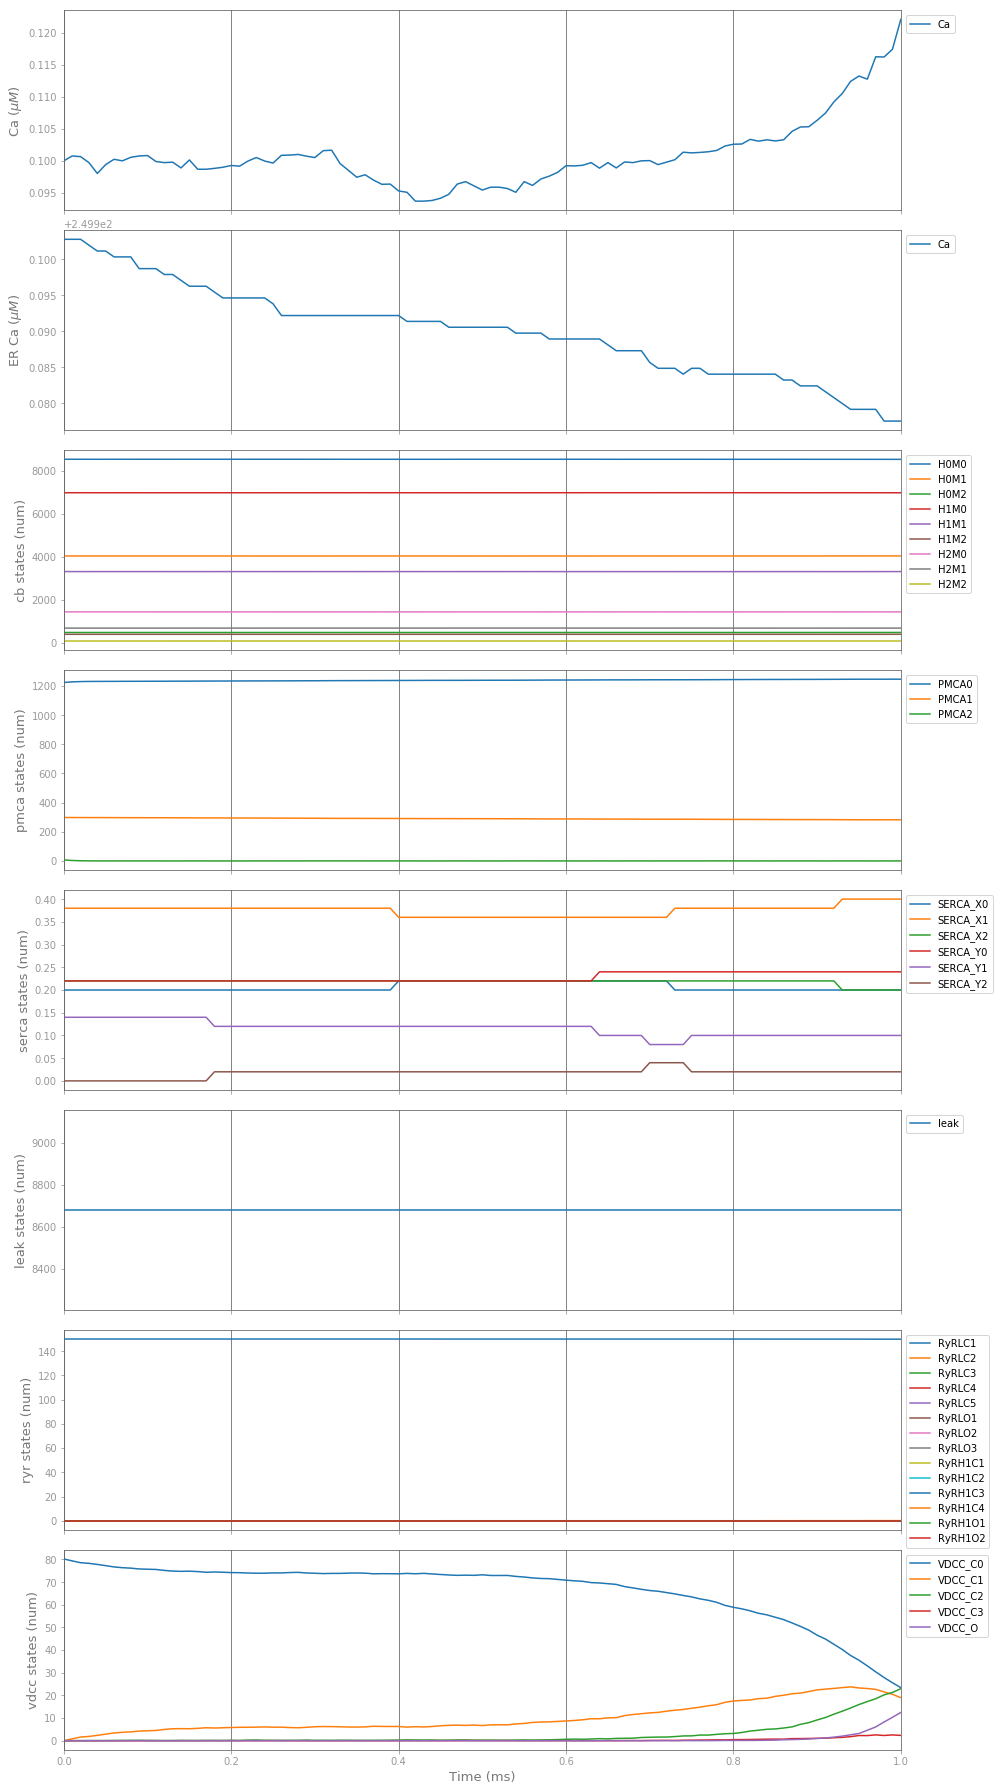

In [26]:
nFig = 2 + len(mParts)
figure, ax = plt.subplots(nFig, figsize=(15, 4*nFig), sharex=True)
figure.subplots_adjust(hspace=0.1)
labelfontsize = 13

t_millisec = T*1e3
j = 0
pos = 0
ax[j].plot(t_millisec, mean[:,pos]*1e6, label='Ca')#/NA/cytVolVal*1e3
ax[j].set_ylabel(r'Ca ($\mu M$)', fontsize=labelfontsize)
j += 1
pos += 1

ax[j].plot(t_millisec, mean[:,pos]*1e6, label='Ca') #/NA/erVolVal*1e3
ax[j].set_ylabel(r'ER Ca ($\mu M$)', fontsize=labelfontsize)
j += 1
pos += 1

for p in base_mParts+['ryr','vdcc']:
    for i,mol in enumerate(MPs[p].molnames):
        ax[j].plot(t_millisec, mean[:,i+pos], label=mol)
    ax[j].set_ylabel(p+' states (num)', fontsize=labelfontsize)
    j += 1
    pos += MPs[p].mol_num
    #print(MPs[p].mol_num,MPs[p].molnames,pos)
print(pos)

ax[-1].set_xlabel('Time (ms)', fontsize=labelfontsize)

facecol = '#ffffff11'
labelcol = '#777777'
tickcol = '#999999'
spinecol = '#666666'
for x in ax:
    x.legend(loc='upper left', facecolor='white', framealpha=0.8, bbox_to_anchor=(1,1))
    
    x.set_xlim(min(t_millisec), max(t_millisec))
    
    x.spines['bottom'].set_color(spinecol)
    x.spines['top'].set_color(spinecol)
    x.spines['right'].set_color(spinecol)
    x.spines['left'].set_color(spinecol)
    
    x.xaxis.label.set_color(labelcol)
    x.yaxis.label.set_color(labelcol)
    
    x.tick_params(axis='x', colors=tickcol)
    x.tick_params(axis='y', colors=tickcol)
    
    x.set_facecolor(facecol)#'xkcd:salmon')
    
    x.grid(axis='x', color=spinecol)

plt.savefig('geometry_working.pdf', dpi=300, format='pdf', transparent=True, bbox_inches=None, pad_inches=0.1)
#plt.show()

### ryr opening

In [ ]:
ss = np.sum(mean[:,[75-14+i-5 for i in [5,6,7,12,13]]].T, axis=0)
plt.plot(t_millisec, ss)
#for i,mol in enumerate(MPs['ryr'].molnames):
#    plt.plot(t_millisec, mean[:,75-14:75], label=mol)
#ax[j].set_ylabel('RyR states (num)', fontsize=labelfontsize)
#    j += 1